In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
for dirname, _, filenames in os.walk('data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



data\BB_Rates_15min_from_10-2023.xlsx


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from matplotlib import pyplot
import pandas as pd
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns 
file_path = 'data\BB_Rates_15min_from_10-2023.xlsx'
data = pd.read_excel(file_path)


In [3]:
start_index = 3
EURUSD = data.iloc[start_index:, :2]

# Rename the columns
EURUSD.columns = ['Dates', 'Close']

# Display the first few rows of the new dataset to verify
print(EURUSD.tail())

                     Dates   Close
13539  2024-04-17 09:30:00  1.0632
13540  2024-04-17 09:45:00  1.0625
13541  2024-04-17 10:00:00   1.063
13542  2024-04-17 10:15:00  1.0642
13543  2024-04-17 10:30:00  1.0647


In [4]:
# Convertiere 'Dates' spalte zu Datetime format
EURUSD['Dates'] = pd.to_datetime(EURUSD['Dates'])
#EURUSD.head()


In [5]:
EURUSD['Dates'] = pd.to_datetime(EURUSD['Dates'])

# Extrahieren aller Datenpunkte, die zum 4. Oktober 2023 gehören
subset = EURUSD[EURUSD['Dates'].dt.date == pd.to_datetime('2023-10-04').date()]

In [6]:
days_full = pd.DataFrame(EURUSD)

In [7]:
days_full['Dates'] = pd.to_datetime(days_full['Dates'])

In [8]:
## Daten in datetime-date objekt umwandeln und dann gruppieren
days_full['Dates'] = days_full['Dates'].dt.date
entries_per_day = days_full.groupby('Dates').size()
full_days = entries_per_day[entries_per_day == 96].index
print(full_days)

Index([2023-10-04, 2023-10-05, 2023-10-09, 2023-10-10, 2023-10-11, 2023-10-12,
       2023-10-16, 2023-10-17, 2023-10-18, 2023-10-19,
       ...
       2024-04-01, 2024-04-02, 2024-04-03, 2024-04-04, 2024-04-08, 2024-04-09,
       2024-04-10, 2024-04-11, 2024-04-15, 2024-04-16],
      dtype='object', name='Dates', length=109)


In [9]:

full_days_df = days_full[days_full['Dates'].isin(full_days)]

print(len(full_days_df))

10464


In [10]:
daily_series = []

# Iteriert über volle Tage und extrahiert die Zeitreihen
for day in full_days:
    daily_data = full_days_df[full_days_df['Dates'] == day]['Close'].values
    daily_series.append(daily_data)
daily_series_array = np.array(daily_series, dtype=np.float32)
print(daily_series_array)
# datetimes als index gesetzt macht paar Sachen einfacher
full_days_df = full_days_df.set_index('Dates')

[[1.0468 1.0467 1.0467 ... 1.0506 1.0506 1.0507]
 [1.0508 1.0508 1.0506 ... 1.0549 1.0549 1.0549]
 [1.0552 1.0552 1.0555 ... 1.0566 1.0566 1.0566]
 ...
 [1.0741 1.0743 1.0743 ... 1.0727 1.0728 1.0727]
 [1.0642 1.0648 1.0651 ... 1.0625 1.0625 1.0625]
 [1.0626 1.0627 1.0627 ... 1.0618 1.0617 1.0617]]


In [11]:
dataset = torch.tensor(daily_series_array)  
train_size = int(0.8*len(dataset))
test_size = len(dataset)-train_size
print(train_size)
print(test_size)

## TODO:
#scaler bauen
# targets bauen für t+1
# momente ausrechnen?
# dataset bauen

train_data, test_data = train_test_split(dataset, test_size=test_size, random_state=42)
train_data = train_data.unsqueeze(-1)
test_data = test_data = test_data.unsqueeze(-1)
train_data.shape

87
22


torch.Size([87, 96, 1])

In [12]:
batch_size = 16
train_loader  = torch.utils.data.DataLoader(train_data, batch_size= batch_size, shuffle=True)
test_loader   = torch.utils.data.DataLoader(test_data, batch_size= batch_size, shuffle=True)

In [13]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(Encoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.bi_lstm = nn.LSTM(input_dim, hidden_dim, num_layers, bidirectional=True, batch_first=True)
        
    def forward(self, x):
        h_0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_dim).to(x.device) # *2 für bidirektional
        c_0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_dim).to(x.device)
        
        output, (hidden, cell) = self.bi_lstm(x, (h_0, c_0))
        return output, hidden, cell


class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.hidden_dim = hidden_dim
        self.attn = nn.Linear(self.hidden_dim*2, hidden_dim)  # *2 für bidirektional
        self.v = nn.Linear(hidden_dim, 1, bias=False)
        
    def forward(self, encoder_outputs, hidden):
        timestep = encoder_outputs.size(1)
        h = hidden[-1].unsqueeze(1).repeat(1, timestep, 1)
        attn_energies = self.score(h, encoder_outputs)
        return torch.softmax(attn_energies, dim=1)
    
    def score(self, hidden, encoder_outputs):
        energy = torch.tanh(self.attn(torch.cat([hidden, encoder_outputs], dim=2)))
        energy = self.v(energy).squeeze(2)
        return energy


class Decoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, num_layers):
        super(Decoder, self).__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.attention = Attention(hidden_dim)
        self.lstm = nn.LSTM(hidden_dim*2, hidden_dim, num_layers, batch_first=True)  # *2 für bidirektionale Ausgabe
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x, encoder_outputs, hidden, cell):
        attn_weights = self.attention(encoder_outputs, hidden)
        context = attn_weights.unsqueeze(1).bmm(encoder_outputs)
        
        lstm_input = torch.cat([x, context], dim=2)
        output, (hidden, cell) = self.lstm(lstm_input, (hidden, cell))
        
        output = self.fc(output.squeeze(1))
        return output, hidden, cell


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, src, trg, trg_len):
        encoder_outputs, hidden, cell = self.encoder(src)
        outputs = torch.zeros(trg.size(0), trg.size(1), self.decoder.output_dim).to(src.device)
        
        input = trg[:, 0, :].unsqueeze(1)
        
        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(input, encoder_outputs, hidden, cell)
            outputs[:, t, :] = output
            input = output.unsqueeze(1)
        
        return outputs


In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
# Hyperparameter
input_dim = 96  # Anzahl der Merkmale in den Eingabedaten
hidden_dim = 128
output_dim = 96  # Anzahl der Merkmale in den Ausgabedaten
num_layers = 2
learning_rate = 0.001
num_epochs = 50

# Modelle initialisieren
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder = Encoder(input_dim, hidden_dim, num_layers)
decoder = Decoder(output_dim, hidden_dim, num_layers)
model = Seq2Seq(encoder, decoder).to(device)





In [16]:
def vae_loss(recon_x, x, mu, logvar):
    # Reconstruction losses are calculated using Mean Squared Error (MSE) and 
    # summed over all elements and batch
    mse_loss = nn.MSELoss(reduction = 'sum')(recon_x, x)

    # See Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    kld_loss = 1/2*torch.sum(1+logvar -mu.pow(2) - logvar.exp())

    total_loss = mse_loss - kld_loss

    return total_loss, mse_loss, kld_loss

In [17]:
import time
import numpy as np
import torch
import fastprogress

def train(train_loader, optimizer, model, loss_fn, master_bar):
    total_loss = 0
    mse_loss = 0
    kl_loss = 0.
    
    for data in fastprogress.progress_bar(train_loader, parent=master_bar):
        model.train()
        inputs = data
      
       
       # print(type(inputs[0]))
        inputs = [tensor.to(device) for tensor in data]
        inputs = torch.stack(inputs).squeeze(0).float()
        #print(inputs.shape)
        #print(inputs.size())
        optimizer.zero_grad()
        
        pred, mu, logvar = model(inputs)
        
        t_loss, m_loss, k_loss = loss_fn(pred, inputs, mu, logvar)
        t_loss.backward()
        optimizer.step()
        
        total_loss += t_loss.item()
        mse_loss += m_loss.item()
        kl_loss += k_loss.item()
        
    return total_loss, mse_loss, kl_loss

def test_set_loss(test_dataloader, model, loss_function, master_bar):
    total_loss = 0
    mse_loss = 0
    kl_loss = 0.
    
    with torch.no_grad():
        for data in fastprogress.progress_bar(test_dataloader, parent=master_bar):
            model.eval()
            inputs = [tensor.to(device) for tensor in data]
            inputs = torch.stack(inputs).squeeze(0).float()
        
            #inputs = inputs.to(device)
            #inputs = [tensor.to(device) for tensor in inputs]
           #print(inputs.size())
            pred, mu, logvar = model(inputs)

            t_loss, m_loss, k_loss = loss_function(pred, inputs, mu, logvar)

            total_loss += t_loss.item()
            mse_loss += m_loss.item()
            kl_loss += k_loss.item()

    return total_loss, mse_loss, kl_loss

def run_training(model, optimizer, loss_function, num_epochs, 
                 train_dataloader, test_dataloader, verbose=False):
    start_time = time.time()
    master_bar = fastprogress.master_bar(range(num_epochs))
    total_losses, mse_losses, kl_losses = [], [], []
    test_total_losses, test_mse_losses, test_kl_losses = [], [], []

    for epoch in master_bar:
        # Train the model
        total_loss, mse_loss, kl_loss = train(train_dataloader, optimizer, model, 
                                              loss_function, master_bar)

        # Test the model
        test_total_loss, test_mse_loss, test_kl_loss = test_set_loss(test_dataloader, model, 
                                                                     loss_function, master_bar)

        # Save loss for plotting
        total_losses.append(total_loss)
        mse_losses.append(mse_loss)
        kl_losses.append(kl_loss)
        
        test_total_losses.append(test_total_loss)
        test_mse_losses.append(test_mse_loss)
        test_kl_losses.append(test_kl_loss)
        
        if verbose:
            master_bar.write(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {total_loss:.4f}, Test Loss: {test_total_loss:.4f}')

    time_elapsed = np.round(time.time() - start_time, 0).astype(int)
    print(f'Finished training after {time_elapsed} seconds.')
    
    return total_losses, mse_losses, kl_losses, test_total_losses, test_mse_losses, test_kl_losses



In [18]:
epochs = 50

#model = model.to(device)
total_losses, mse_losses, kl_losses, test_total_losses, test_mse_losses, test_kl_losses = run_training(
        model, torch.optim.Adam(model.parameters(), lr=learning_rate), vae_loss, epochs, train_loader, test_loader)


TypeError: Seq2Seq.forward() missing 2 required positional arguments: 'trg' and 'trg_len'

: 

In [ ]:
#input_data = torch.tesor([])
#future_steps = 96  # Anzahl der zukünftigen Schritte, die vorhergesagt werden sollen
#predicted_future = model.predict_future(input_data, future_steps)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:

def plot(title, label, train_results, val_results, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None):
    """Plot learning curves.

    Args:
        title (str): Title of plot
        label (str): x-axis label
        train_results (list): Results vector of training of length of number
            of epochs trained. Could be loss or accuracy.
        val_results (list): Results vector of validation of length of number
            of epochs. Could be loss or accuracy.
        yscale (str, optional): Matplotlib.pyplot.yscale parameter. 
            Defaults to 'linear'.
        save_path (str, optional): If passed, figure will be saved at this path.
            Defaults to None.
        extra_pt (tuple, optional): Tuple of length 2, defining x and y coordinate
            of where an additional black dot will be plotted. Defaults to None.
        extra_pt_label (str, optional): Legend label of extra point. Defaults to None.
    """
    
    epoch_array = np.arange(len(train_results)) + 1
    train_label, val_label = "Training "+label.lower(), "Test "+label.lower()
    
    sns.set(style='ticks')

    plt.plot(epoch_array, train_results, epoch_array, val_results, linestyle='dashed', marker='o')
    legend = ['Train results', 'test results']
    
    if extra_pt:
        ####################
        ## YOUR CODE HERE ##
        ####################
        #raise NotImplementedError # Comment out this keyword after your implementation
        plt.scatter(extra_pt[0], extra_pt[1], color="k", s=50, zorder=4)
        plt.text(extra_pt[0], extra_pt[1], extra_pt_label)

        # END OF YOUR CODE #
        
    plt.legend(legend)
    plt.xlabel('Epoch')
    plt.ylabel(label)
    plt.yscale(yscale)
    plt.title(title)
    
    sns.despine(trim=True, offset=5)
    plt.title(title, fontsize=15)
    if save_path:
        plt.savefig(str(save_path), bbox_inches='tight')
    plt.show()

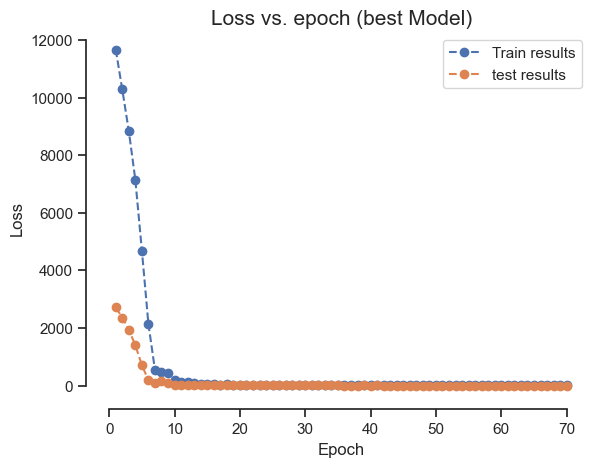

[2714.1043090820312, 2361.891845703125, 1944.9793090820312, 1396.4695739746094, 707.0841217041016, 184.72066497802734, 101.2463321685791, 141.97779846191406, 73.64306831359863, 34.16482925415039, 25.987241744995117, 19.89635419845581, 14.001846075057983, 12.323741912841797, 11.07254409790039, 8.452770233154297, 6.253347158432007, 5.055297613143921, 4.942236542701721, 5.290834307670593, 4.431732654571533, 3.220139265060425, 2.4831994771957397, 2.2184531688690186, 1.9441740214824677, 1.635428786277771, 1.3045347332954407, 1.24400994181633, 1.2536954879760742, 1.1437900066375732, 0.983538493514061, 0.7450919151306152, 0.7705646604299545, 0.8555746674537659, 0.7105888873338699, 0.6050867289304733, 0.5657031387090683, 0.6271772608160973, 0.6700315922498703, 0.6103090643882751, 0.6571371480822563, 0.5541775450110435, 0.5011605769395828, 0.5533633530139923, 0.5723361968994141, 0.4857499450445175, 0.5102323144674301, 0.5414759814739227, 0.4898281842470169, 0.48948080837726593, 0.54123505949974

: 

In [ ]:
best_loss = None
plot("Loss vs. epoch (best Model)", "Loss", total_losses, test_total_losses, yscale='linear', extra_pt=best_loss, extra_pt_label="best loss")
print(test_total_losses)

In [ ]:
class Predictor(nn.Module):
    def __init__(self, vae_lstm, prediction_steps):
        super(Predictor, self).__init__()
        self.vae_lstm = vae_lstm
        self.prediction_steps = prediction_steps

    def forward(self, x):
        # Use the VAE LSTM to get the latent representation of the input
        _, mu, logvar = self.vae_lstm(x)

        # Use the latent representation to predict the next steps in the time series
        predictions = []
        for _ in range(self.prediction_steps):
            # Use the last prediction as input for the next prediction
            x, _, _ = self.vae_lstm(x)
            predictions.append(x)

        return torch.stack(predictions, dim=1)